<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/Gan_%EC%B2%AB%EA%B1%B8%EC%9D%8C/%EC%86%90%EC%9C%BC%EB%A1%9C_%EC%93%B4_%EC%88%AB%EC%9E%90_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

### MNIST Dataset

In [14]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [15]:
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # normalization
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')

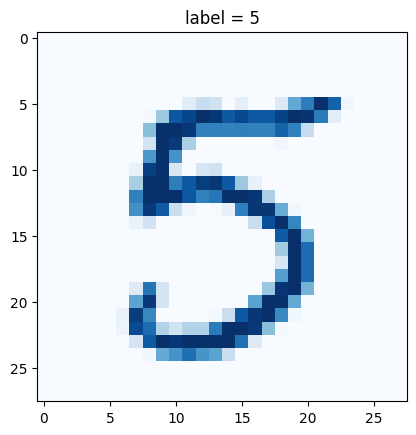

In [17]:
mnist_dataset = MnistDataset('./sample_data/mnist_train_small.csv')
mnist_dataset.plot_image(1)

### MNIST 판별기

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # 손실합수 옵티마이저 설정
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        # 훈련 과정 추적을 위한 변수
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        # 출력 계산
        outputs = self.forward(inputs)

        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        # 기울기 초기화, 역전파, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5))

### 판별기 테스트

In [22]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(784), torch.FloatTensor([0.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 27.1 s, sys: 77.9 ms, total: 27.1 s
Wall time: 30.4 s


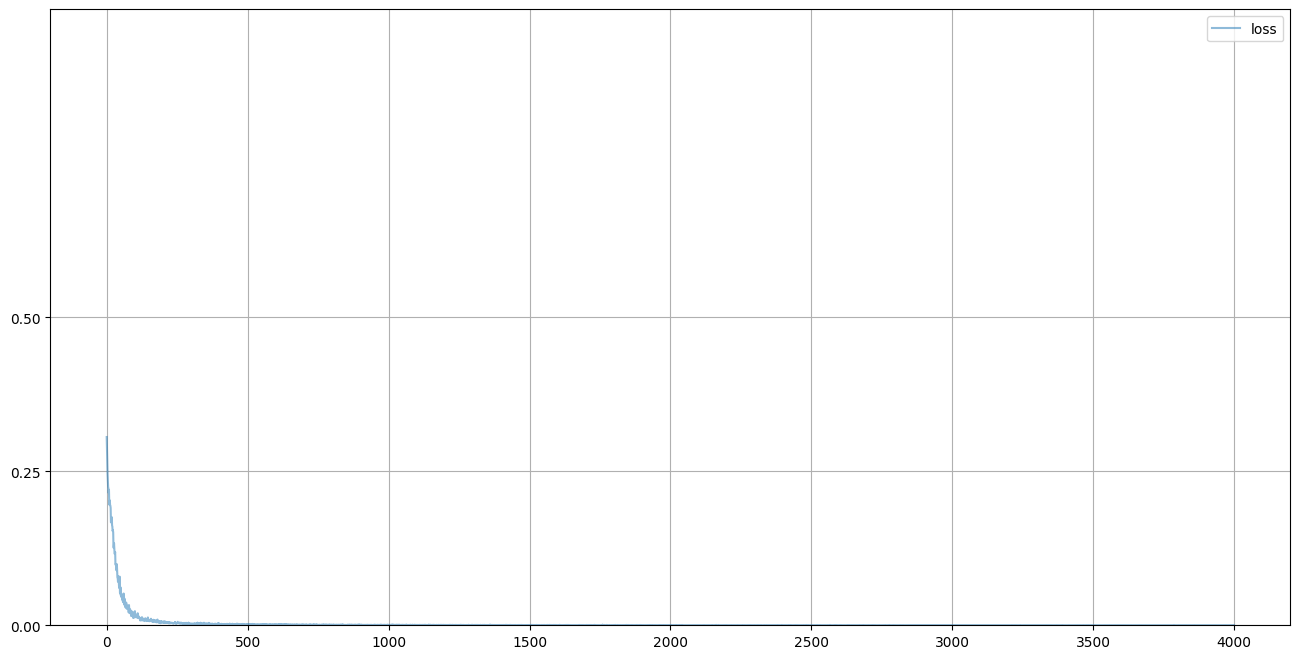

In [20]:
D.plot_progress()

In [23]:
# 실제 데이터
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0, 10000)][1]
    print( D.forward( image_data_tensor ).item() )

# Fake 데이터
for i in range(4):
    print( D.forward( generate_random(784) ).item() )

0.9896281957626343
0.9961915016174316
0.9764214158058167
0.9883604049682617
0.010246532037854195
0.009942584671080112
0.0068398634903132915
0.008649826981127262


### MNIST 생성기

In [24]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.Sigmoid(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # 옵티마이저 설정 (손실함수는 설정하지 않음)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        # 훈련 과정 추적을 위한 변수
        self.counter = 0
        self.progress = []

    def forward(self, inputs): # 가독성을 키우기 위해 다음과 같이 사용
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # 생성기 출력 계산
        g_outputs = self.forward(inputs)

        # 생성기 출력값을 판별기로 전달
        d_outputs = D.forward(g_outputs)

        # 오차 계산
        loss = D.loss_function(d_outputs, targets)

        # 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        # if (self.counter % 10000 == 0): # 판별기 학습 코드에 출력문이 있기 때문에 중복 출력 방지
        #     print("counter = ", self.counter)

        # 기울기 초기화, 역전파, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5))

### 생성기 테스트
- 입력
  - 임의의 시드를 사용해서 숫자를 생성해야함
    - 같은 입력에 대해서는 언제나 같은 출력
    - 즉, 조금씩 다른 숫자가 다양한 이미지를 생성하는데 도움을 줌

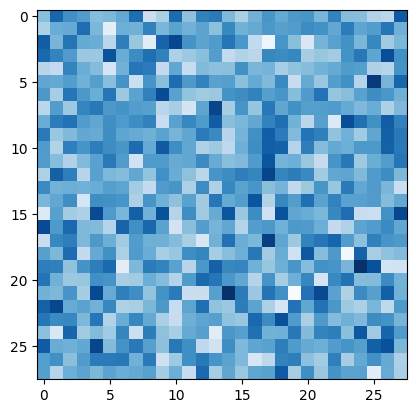

In [25]:
G = Generator()

output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')

### GAN 훈련하기

In [33]:
%%time

D = Discriminator()
G = Generator()
for _ in range(3): # 데이터 수가 적어 반복
    for label, image_data_tensor, target_tensor in mnist_dataset:
        # 실제 데이터 (판별기 훈련)
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
        # 생성 데이터 (판별기 훈련)
        D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
        # 생성기 훈련
        G.train(D, generate_random(1), torch.FloatTensor([1.0]))

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 2min 26s, sys: 297 ms, total: 2min 27s
Wall time: 2min 33s


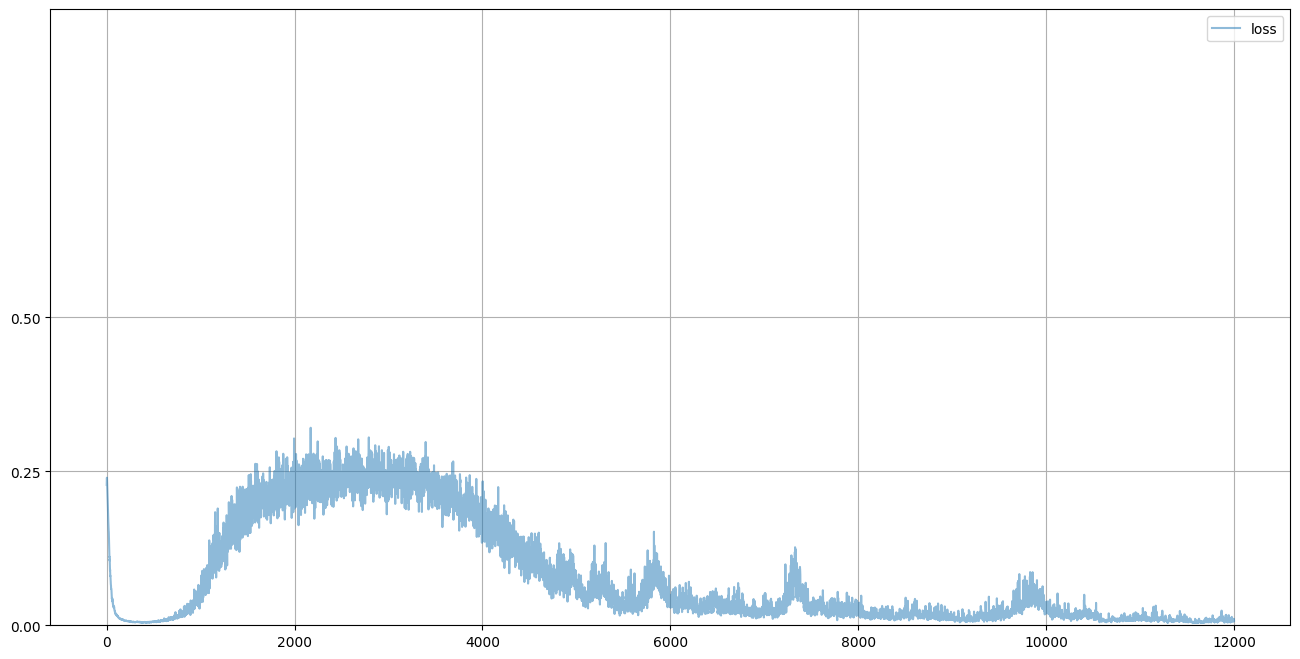

In [34]:
D.plot_progress()

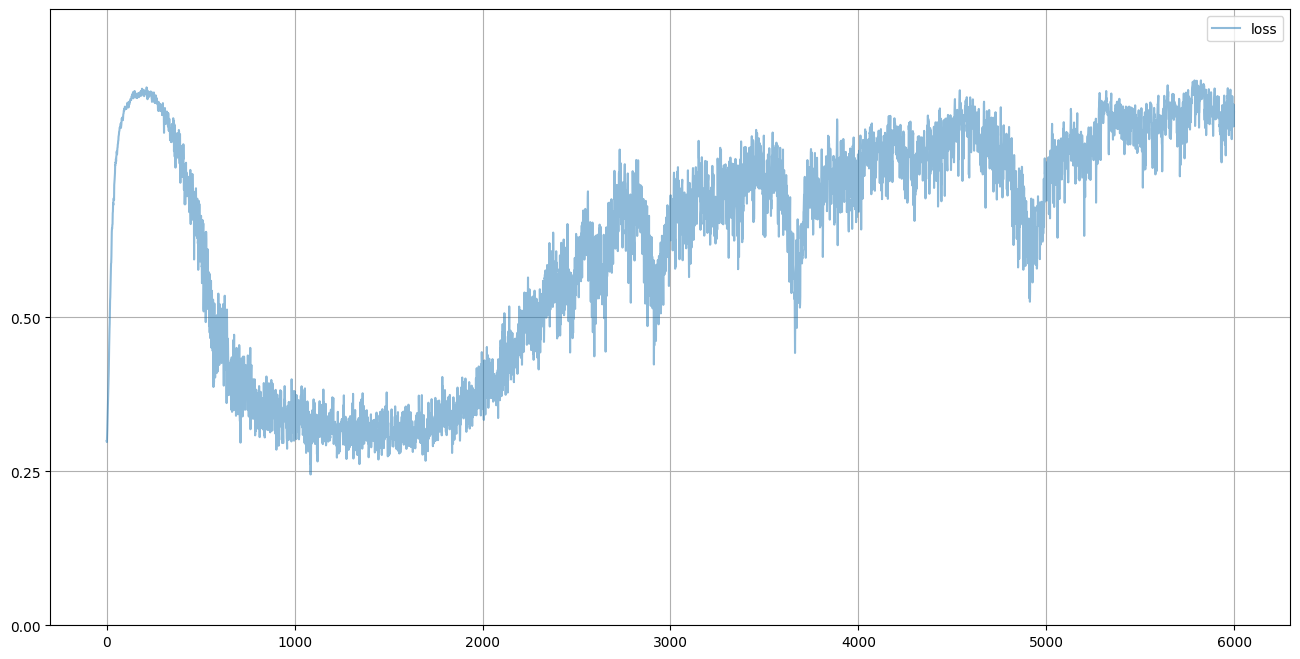

In [35]:
G.plot_progress()

- 초반에는 판별기의 성능이 생성기를 앞섬
- 0.25 부근에서 머무는 듯 하였으나
  - (생성기와 판별기의 균형이 맞음)
-  이후 다시 판별기의 성능이 생성기를 앞섬

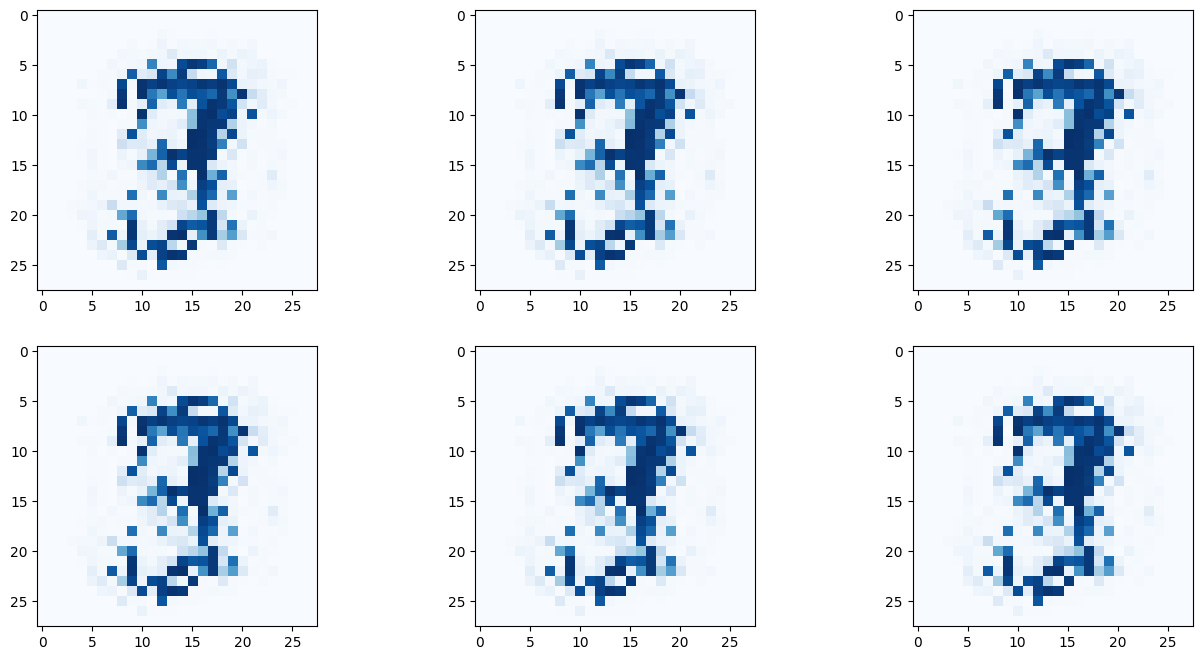

In [36]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

- 숫자와 비슷한 형태를 보임
- 하지만 이미지들이 모두 똑같이 생김
  - 이를 모드 **모드 붕괴** 현상 이라 함

### GAN 훈련 성능 향상하기 1
1. 손실함수 변경
  - 평균제곱 오차(MSE) -> 이진교차엔트로피 (BCE)
2. 모델 변경
  - LeakyReLU, LayerNorm 추가
3. 옵티마이저 변경
  - SGD -> Adam

In [74]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 모델 변경
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # 손실합수 옵티마이저 변경
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))


In [75]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # 모델 변경
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # 옵티마이저 변경
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_outputs = self.forward(inputs)
        d_outputs = D.forward(g_outputs)
        loss = D.loss_function(d_outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [76]:
%%time

D = Discriminator()
G = Generator()

epochs = 3
for epoch in range(epochs): # 데이터 수가 적어 반복
    print("epoch = ", epoch + 1)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        # 실제 데이터 (판별기 훈련)
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
        # 생성 데이터 (판별기 훈련)
        D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
        # 생성기 훈련
        G.train(D, generate_random(1), torch.FloatTensor([1.0]))

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
epoch =  2
counter =  50000
counter =  60000
counter =  70000
counter =  80000
epoch =  3
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 59s, sys: 566 ms, total: 4min 59s
Wall time: 5min 12s


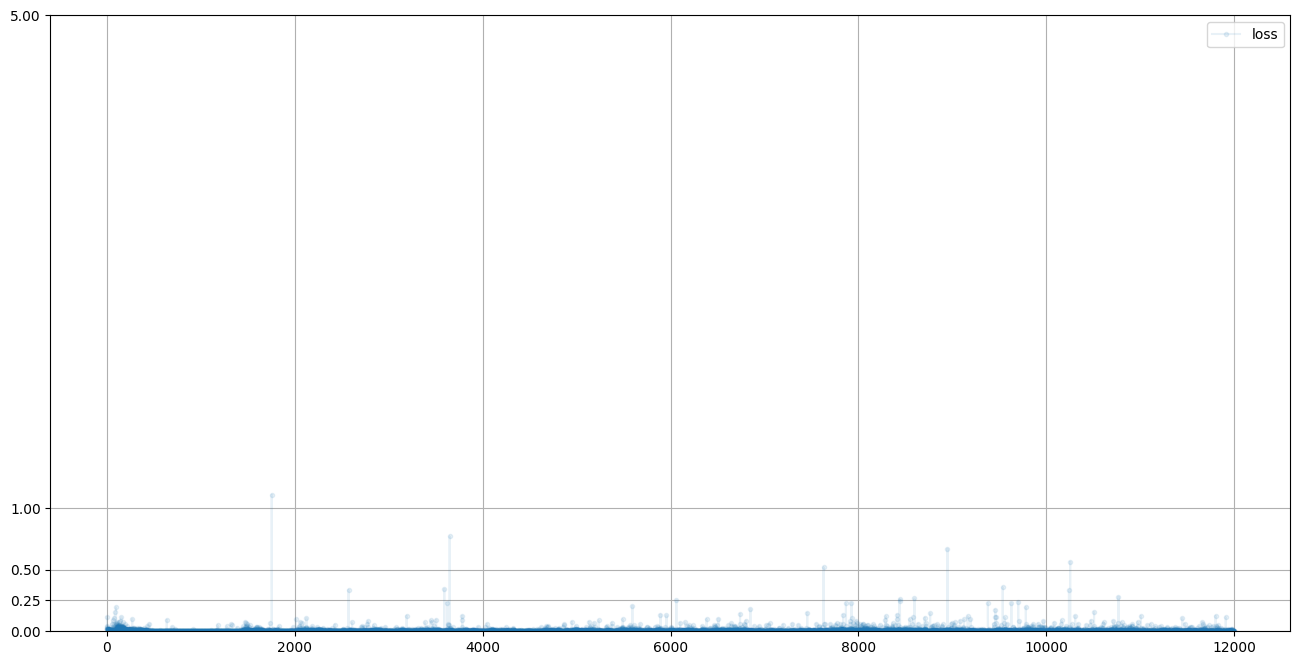

In [77]:
D.plot_progress()

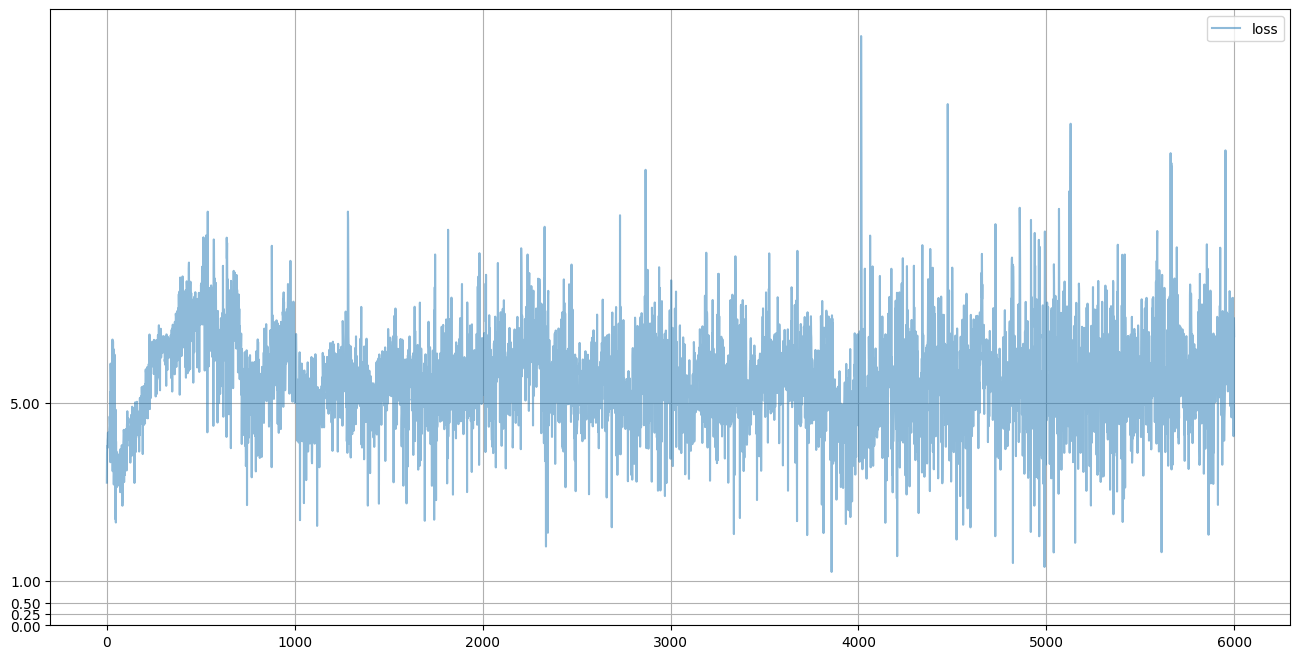

In [78]:
G.plot_progress()

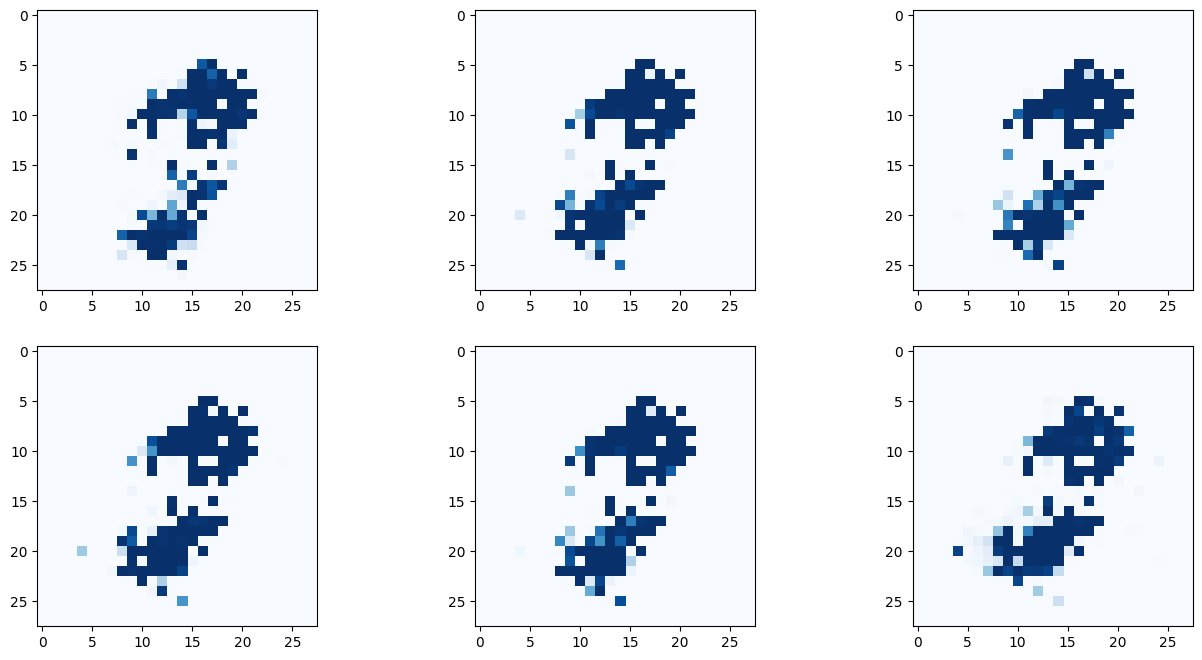

In [79]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

- 모드 붕괴 현상은 그대로

### GAN 훈련 성능 향상하기 2
1. 생성기 입력 노드 변경
  - 하나의 값 만으로 생성기가 10개의 숫자를 생성하지 못했다고 판단
    - 임의의 값으로 입력노드를 100개로 증가
  - 시드의 범위를 정규분포에서 추출

In [80]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # 모델 변경
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # 옵티마이저 변경
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_outputs = self.forward(inputs)
        d_outputs = D.forward(g_outputs)
        loss = D.loss_function(d_outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])

        df.plot(ylim=(0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [81]:
def generate_random_seed(size): # (152page)
    random_data = torch.randn(size)
    return random_data

In [82]:
%%time

D = Discriminator()
G = Generator()

epochs = 3
for epoch in range(epochs): # 데이터 수가 적어 반복
    print("epoch = ", epoch + 1)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        # 실제 데이터 (판별기 훈련)
        D.train(image_data_tensor, torch.FloatTensor([1.0]))
        # 생성 데이터 (판별기 훈련)
        D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
        # 생성기 훈련
        G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
epoch =  2
counter =  50000
counter =  60000
counter =  70000
counter =  80000
epoch =  3
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 4min 57s, sys: 574 ms, total: 4min 57s
Wall time: 5min 4s


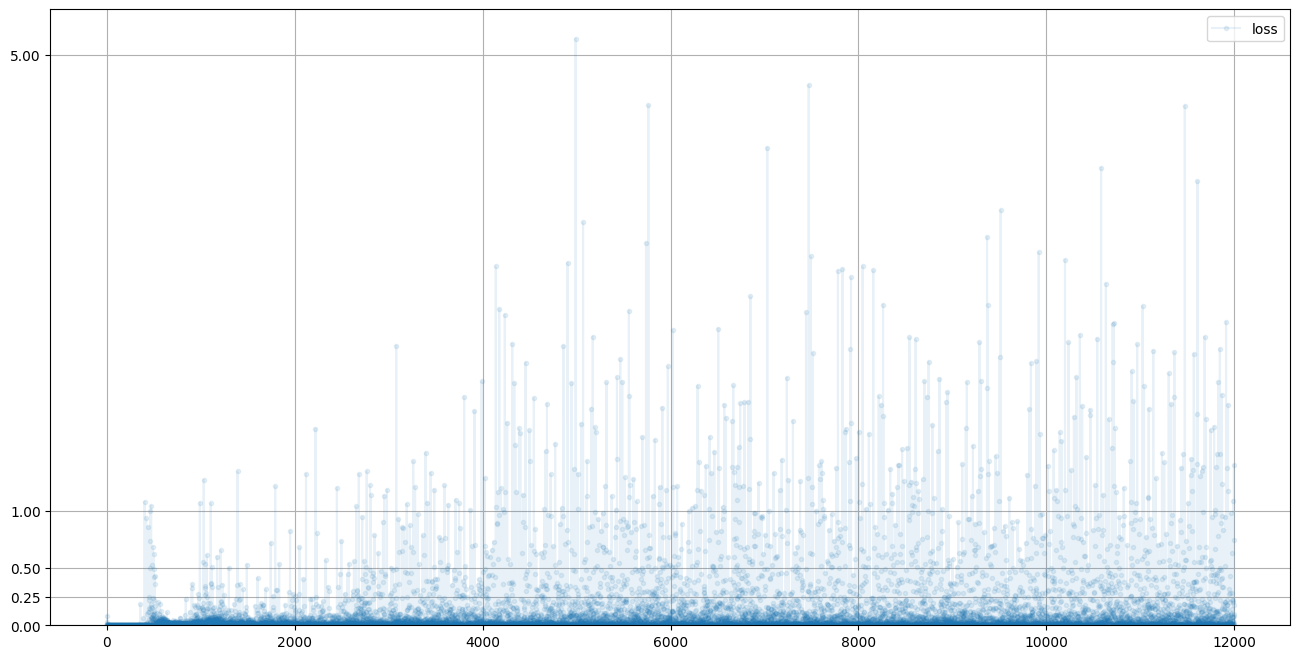

In [83]:
D.plot_progress()

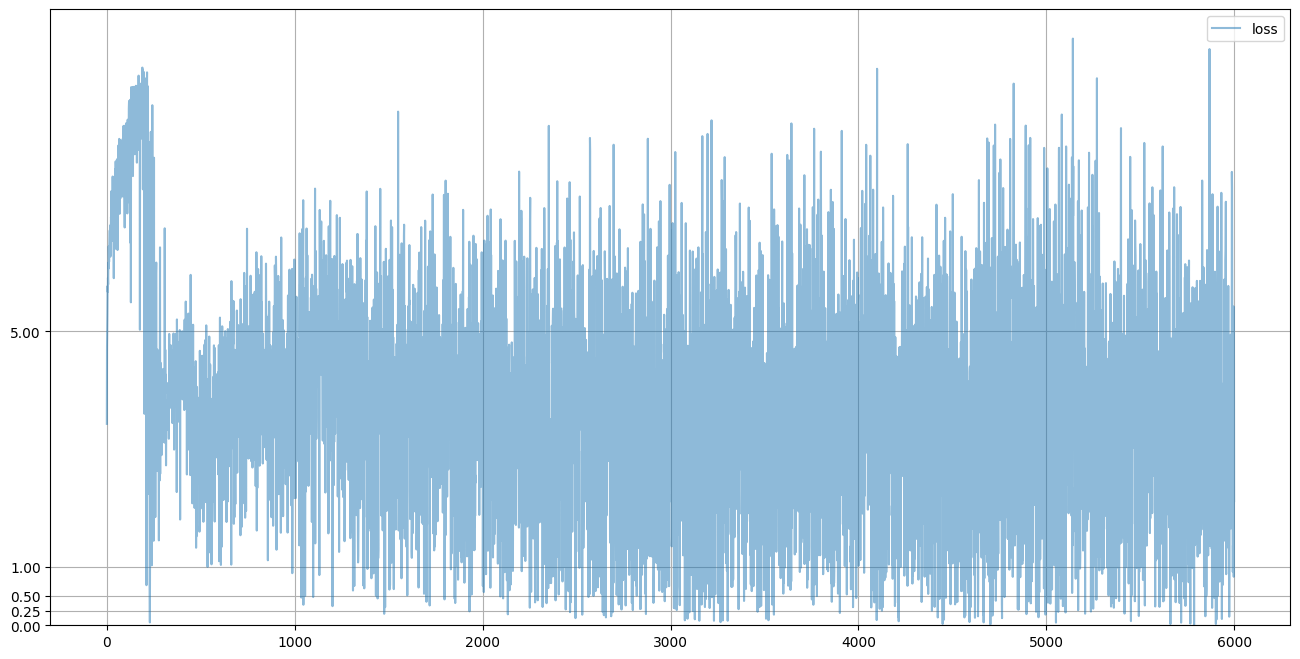

In [84]:
G.plot_progress()

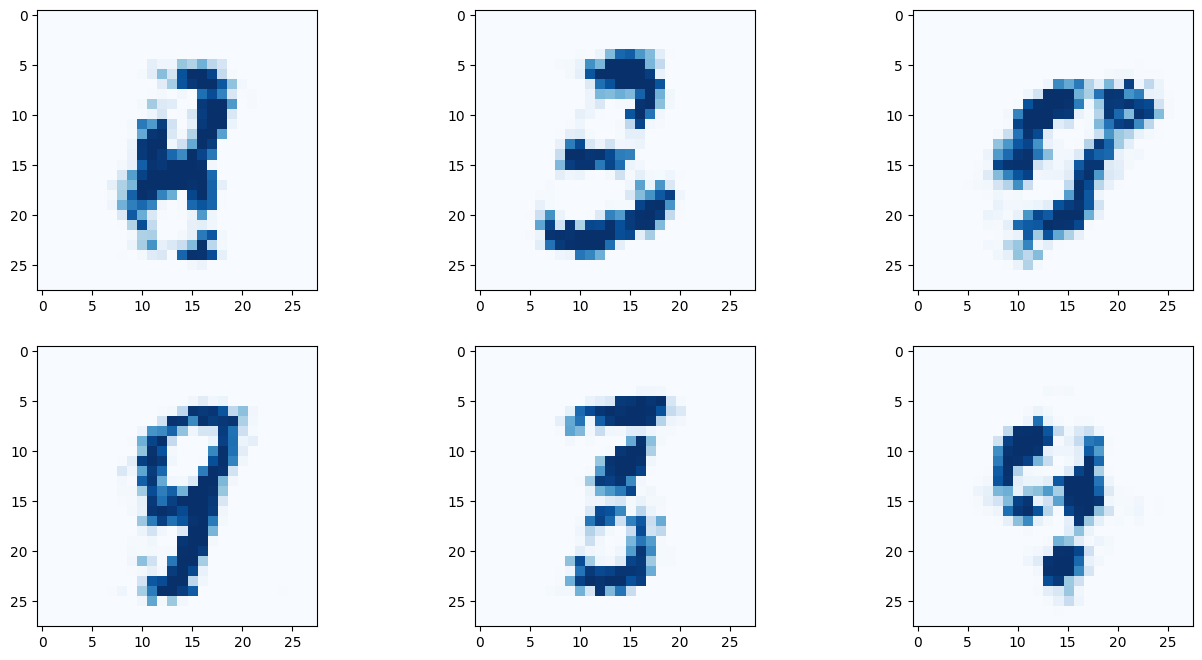

In [86]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')

- 모드 붕괴 현상은 해결했지만 성능이 별로 좋지않음
- 손실 차트
  - 판별기
    - 손실이 빠르게 0으로 수렴하고 유지되지면 가끔 점프
    - 균형이 맞춰지지 않았다는 의미
  - 생성기
    - 손실이 오르지만 떨어진 이후에는 3 근처에 머무름
    - 생성기의 손실은 깔끔하게 증거하는 것보다 어느정도 고정된 값을 중심으로 약간의 변화가 있는 것이 바람직함
  - BCE Loss가 어떤 값을 가져야하는가
    - 이진 교차엔트로피의 수학적 정의에 의해 ln(2) == 0.693이 바람직함

### 시드로 실험하기
- 시드의 몇가지 특성 파악

##### 1. 두 시드의 중간값은?

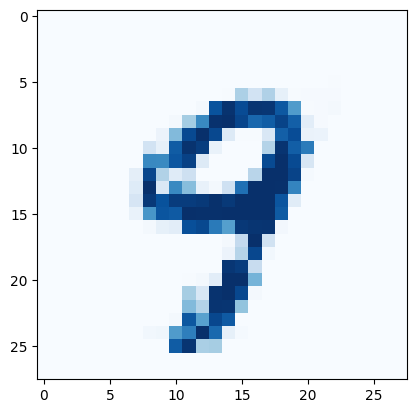

In [89]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

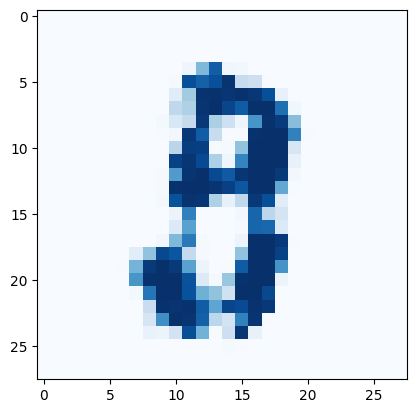

In [92]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

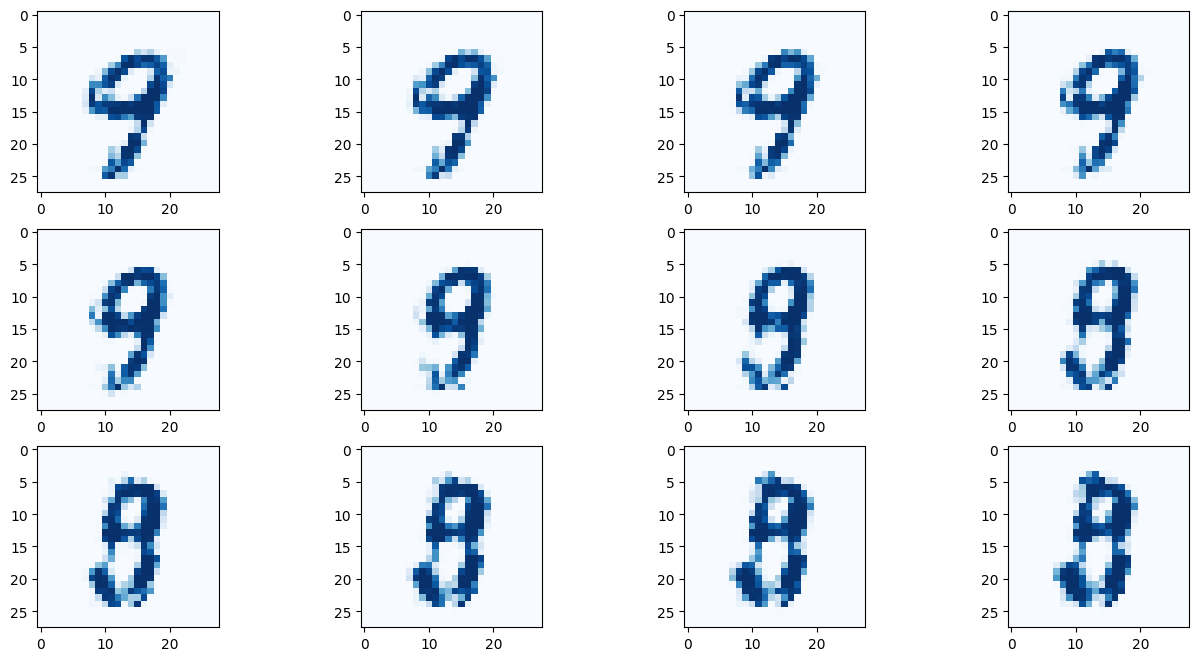

In [94]:
count = 0

f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1

- 두 시드 일정한 간격으로 출력
  - 숫자가 점점 변경되는 것을 볼 수 있음

##### 2. 두 시드의 합은?
- 말 그대로 이미지를 섞은 느낌

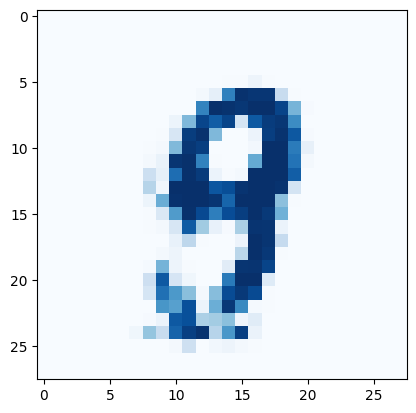

In [98]:
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

##### 3. 두 시드의 차이 값은?
- 애매함
- 단순한 규칙(직관적인 패턴)이 아닌 것을 확인할 수 있음

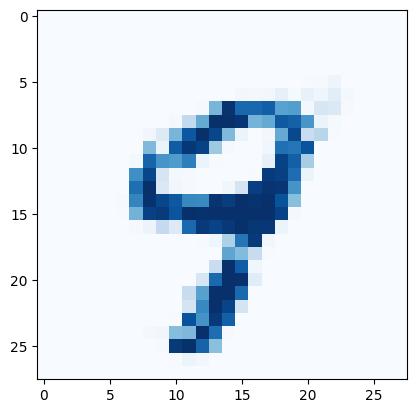

In [96]:
seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

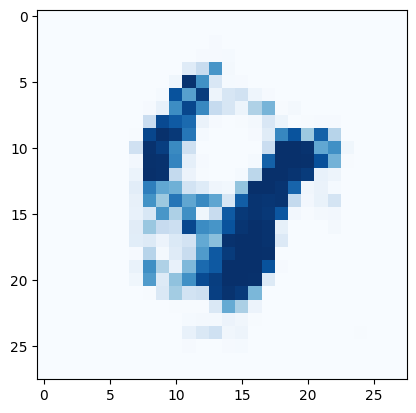

In [97]:
seed4 = seed1 * seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')

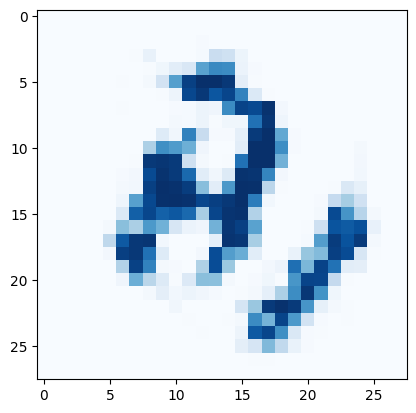

In [99]:
seed4 = seed1 / seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')